<a href="https://colab.research.google.com/github/DDGanji/GanjiPythonClass/blob/main/laplace_ok1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Natural Language Toolkit: Collections
#
# Copyright (C) 2001-2021 NLTK Project
# Author: Steven Bird <stevenbird1@gmail.com>
# URL: <http://nltk.org/>
# For license information, see LICENSE.TXT

import bisect

# this unused import is for python 2.7
from collections import Counter, defaultdict, deque
from functools import total_ordering
from itertools import chain, islice

from nltk.internals import raise_unorderable_types, slice_bounds

##########################################################################
# Ordered Dictionary
##########################################################################


class OrderedDict(dict):
    def __init__(self, data=None, **kwargs):
        self._keys = self.keys(data, kwargs.get("keys"))
        self._default_factory = kwargs.get("default_factory")
        if data is None:
            dict.__init__(self)
        else:
            dict.__init__(self, data)

    def __delitem__(self, key):
        dict.__delitem__(self, key)
        self._keys.remove(key)

    def __getitem__(self, key):
        try:
            return dict.__getitem__(self, key)
        except KeyError:
            return self.__missing__(key)

    def __iter__(self):
        return (key for key in self.keys())

    def __missing__(self, key):
        if not self._default_factory and key not in self._keys:
            raise KeyError()
        return self._default_factory()

    def __setitem__(self, key, item):
        dict.__setitem__(self, key, item)
        if key not in self._keys:
            self._keys.append(key)

    def clear(self):
        dict.clear(self)
        self._keys.clear()

    def copy(self):
        d = dict.copy(self)
        d._keys = self._keys
        return d

    def items(self):
        # returns iterator under python 3 and list under python 2
        return zip(self.keys(), self.values())

    def keys(self, data=None, keys=None):
        if data:
            if keys:
                assert isinstance(keys, list)
                assert len(data) == len(keys)
                return keys
            else:
                assert (
                    isinstance(data, dict)
                    or isinstance(data, OrderedDict)
                    or isinstance(data, list)
                )
                if isinstance(data, dict) or isinstance(data, OrderedDict):
                    return data.keys()
                elif isinstance(data, list):
                    return [key for (key, value) in data]
        elif "_keys" in self.__dict__:
            return self._keys
        else:
            return []

    def popitem(self):
        if not self._keys:
            raise KeyError()

        key = self._keys.pop()
        value = self[key]
        del self[key]
        return (key, value)

    def setdefault(self, key, failobj=None):
        dict.setdefault(self, key, failobj)
        if key not in self._keys:
            self._keys.append(key)

    def update(self, data):
        dict.update(self, data)
        for key in self.keys(data):
            if key not in self._keys:
                self._keys.append(key)

    def values(self):
        # returns iterator under python 3
        return map(self.get, self._keys)


######################################################################
# Lazy Sequences
######################################################################


@total_ordering
class AbstractLazySequence:
    """
    An abstract base class for read-only sequences whose values are
    computed as needed.  Lazy sequences act like tuples -- they can be
    indexed, sliced, and iterated over; but they may not be modified.

    The most common application of lazy sequences in NLTK is for
    corpus view objects, which provide access to the contents of a
    corpus without loading the entire corpus into memory, by loading
    pieces of the corpus from disk as needed.

    The result of modifying a mutable element of a lazy sequence is
    undefined.  In particular, the modifications made to the element
    may or may not persist, depending on whether and when the lazy
    sequence caches that element's value or reconstructs it from
    scratch.

    Subclasses are required to define two methods: ``__len__()``
    and ``iterate_from()``.
    """

    def __len__(self):
        """
        Return the number of tokens in the corpus file underlying this
        corpus view.
        """
        raise NotImplementedError("should be implemented by subclass")

    def iterate_from(self, start):
        """
        Return an iterator that generates the tokens in the corpus
        file underlying this corpus view, starting at the token number
        ``start``.  If ``start>=len(self)``, then this iterator will
        generate no tokens.
        """
        raise NotImplementedError("should be implemented by subclass")

    def __getitem__(self, i):
        """
        Return the *i* th token in the corpus file underlying this
        corpus view.  Negative indices and spans are both supported.
        """
        if isinstance(i, slice):
            start, stop = slice_bounds(self, i)
            return LazySubsequence(self, start, stop)
        else:
            # Handle negative indices
            if i < 0:
                i += len(self)
            if i < 0:
                raise IndexError("index out of range")
            # Use iterate_from to extract it.
            try:
                return next(self.iterate_from(i))
            except StopIteration as e:
                raise IndexError("index out of range") from e

    def __iter__(self):
        """Return an iterator that generates the tokens in the corpus
        file underlying this corpus view."""
        return self.iterate_from(0)

    def count(self, value):
        """Return the number of times this list contains ``value``."""
        return sum(1 for elt in self if elt == value)

    def index(self, value, start=None, stop=None):
        """Return the index of the first occurrence of ``value`` in this
        list that is greater than or equal to ``start`` and less than
        ``stop``.  Negative start and stop values are treated like negative
        slice bounds -- i.e., they count from the end of the list."""
        start, stop = slice_bounds(self, slice(start, stop))
        for i, elt in enumerate(islice(self, start, stop)):
            if elt == value:
                return i + start
        raise ValueError("index(x): x not in list")

    def __contains__(self, value):
        """Return true if this list contains ``value``."""
        return bool(self.count(value))

    def __add__(self, other):
        """Return a list concatenating self with other."""
        return LazyConcatenation([self, other])

    def __radd__(self, other):
        """Return a list concatenating other with self."""
        return LazyConcatenation([other, self])

    def __mul__(self, count):
        """Return a list concatenating self with itself ``count`` times."""
        return LazyConcatenation([self] * count)

    def __rmul__(self, count):
        """Return a list concatenating self with itself ``count`` times."""
        return LazyConcatenation([self] * count)

    _MAX_REPR_SIZE = 60

    def __repr__(self):
        """
        Return a string representation for this corpus view that is
        similar to a list's representation; but if it would be more
        than 60 characters long, it is truncated.
        """
        pieces = []
        length = 5
        for elt in self:
            pieces.append(repr(elt))
            length += len(pieces[-1]) + 2
            if length > self._MAX_REPR_SIZE and len(pieces) > 2:
                return "[%s, ...]" % ", ".join(pieces[:-1])
        return "[%s]" % ", ".join(pieces)

    def __eq__(self, other):
        return type(self) == type(other) and list(self) == list(other)

    def __ne__(self, other):
        return not self == other

    def __lt__(self, other):
        if type(other) != type(self):
            raise_unorderable_types("<", self, other)
        return list(self) < list(other)

    def __hash__(self):
        """
        :raise ValueError: Corpus view objects are unhashable.
        """
        raise ValueError("%s objects are unhashable" % self.__class__.__name__)


class LazySubsequence(AbstractLazySequence):
    """
    A subsequence produced by slicing a lazy sequence.  This slice
    keeps a reference to its source sequence, and generates its values
    by looking them up in the source sequence.
    """

    MIN_SIZE = 100
    """
    The minimum size for which lazy slices should be created.  If
    ``LazySubsequence()`` is called with a subsequence that is
    shorter than ``MIN_SIZE``, then a tuple will be returned instead.
    """

    def __new__(cls, source, start, stop):
        """
        Construct a new slice from a given underlying sequence.  The
        ``start`` and ``stop`` indices should be absolute indices --
        i.e., they should not be negative (for indexing from the back
        of a list) or greater than the length of ``source``.
        """
        # If the slice is small enough, just use a tuple.
        if stop - start < cls.MIN_SIZE:
            return list(islice(source.iterate_from(start), stop - start))
        else:
            return object.__new__(cls)

    def __init__(self, source, start, stop):
        self._source = source
        self._start = start
        self._stop = stop

    def __len__(self):
        return self._stop - self._start

    def iterate_from(self, start):
        return islice(
            self._source.iterate_from(start + self._start), max(0, len(self) - start)
        )


class LazyConcatenation(AbstractLazySequence):
    """
    A lazy sequence formed by concatenating a list of lists.  This
    underlying list of lists may itself be lazy.  ``LazyConcatenation``
    maintains an index that it uses to keep track of the relationship
    between offsets in the concatenated lists and offsets in the
    sublists.
    """

    def __init__(self, list_of_lists):
        self._list = list_of_lists
        self._offsets = [0]

    def __len__(self):
        if len(self._offsets) <= len(self._list):
            for _ in self.iterate_from(self._offsets[-1]):
                pass
        return self._offsets[-1]

    def iterate_from(self, start_index):
        if start_index < self._offsets[-1]:
            sublist_index = bisect.bisect_right(self._offsets, start_index) - 1
        else:
            sublist_index = len(self._offsets) - 1

        index = self._offsets[sublist_index]

        # Construct an iterator over the sublists.
        if isinstance(self._list, AbstractLazySequence):
            sublist_iter = self._list.iterate_from(sublist_index)
        else:
            sublist_iter = islice(self._list, sublist_index, None)

        for sublist in sublist_iter:
            if sublist_index == (len(self._offsets) - 1):
                assert (
                    index + len(sublist) >= self._offsets[-1]
                ), "offsets not monotonic increasing!"
                self._offsets.append(index + len(sublist))
            else:
                assert self._offsets[sublist_index + 1] == index + len(
                    sublist
                ), "inconsistent list value (num elts)"

            yield from sublist[max(0, start_index - index) :]

            index += len(sublist)
            sublist_index += 1


class LazyMap(AbstractLazySequence):
    """
    A lazy sequence whose elements are formed by applying a given
    function to each element in one or more underlying lists.  The
    function is applied lazily -- i.e., when you read a value from the
    list, ``LazyMap`` will calculate that value by applying its
    function to the underlying lists' value(s).  ``LazyMap`` is
    essentially a lazy version of the Python primitive function
    ``map``.  In particular, the following two expressions are
    equivalent:

        >>> from nltk.collections import LazyMap
        >>> function = str
        >>> sequence = [1,2,3]
        >>> map(function, sequence) # doctest: +SKIP
        ['1', '2', '3']
        >>> list(LazyMap(function, sequence))
        ['1', '2', '3']

    Like the Python ``map`` primitive, if the source lists do not have
    equal size, then the value None will be supplied for the
    'missing' elements.

    Lazy maps can be useful for conserving memory, in cases where
    individual values take up a lot of space.  This is especially true
    if the underlying list's values are constructed lazily, as is the
    case with many corpus readers.

    A typical example of a use case for this class is performing
    feature detection on the tokens in a corpus.  Since featuresets
    are encoded as dictionaries, which can take up a lot of memory,
    using a ``LazyMap`` can significantly reduce memory usage when
    training and running classifiers.
    """

    def __init__(self, function, *lists, **config):
        """
        :param function: The function that should be applied to
            elements of ``lists``.  It should take as many arguments
            as there are ``lists``.
        :param lists: The underlying lists.
        :param cache_size: Determines the size of the cache used
            by this lazy map.  (default=5)
        """
        if not lists:
            raise TypeError("LazyMap requires at least two args")

        self._lists = lists
        self._func = function
        self._cache_size = config.get("cache_size", 5)
        self._cache = {} if self._cache_size > 0 else None

        # If you just take bool() of sum() here _all_lazy will be true just
        # in case n >= 1 list is an AbstractLazySequence.  Presumably this
        # isn't what's intended.
        self._all_lazy = sum(
            isinstance(lst, AbstractLazySequence) for lst in lists
        ) == len(lists)

    def iterate_from(self, index):
        # Special case: one lazy sublist
        if len(self._lists) == 1 and self._all_lazy:
            for value in self._lists[0].iterate_from(index):
                yield self._func(value)
            return

        # Special case: one non-lazy sublist
        elif len(self._lists) == 1:
            while True:
                try:
                    yield self._func(self._lists[0][index])
                except IndexError:
                    return
                index += 1

        # Special case: n lazy sublists
        elif self._all_lazy:
            iterators = [lst.iterate_from(index) for lst in self._lists]
            while True:
                elements = []
                for iterator in iterators:
                    try:
                        elements.append(next(iterator))
                    except:  # FIXME: What is this except really catching? StopIteration?
                        elements.append(None)
                if elements == [None] * len(self._lists):
                    return
                yield self._func(*elements)
                index += 1

        # general case
        else:
            while True:
                try:
                    elements = [lst[index] for lst in self._lists]
                except IndexError:
                    elements = [None] * len(self._lists)
                    for i, lst in enumerate(self._lists):
                        try:
                            elements[i] = lst[index]
                        except IndexError:
                            pass
                    if elements == [None] * len(self._lists):
                        return
                yield self._func(*elements)
                index += 1

    def __getitem__(self, index):
        if isinstance(index, slice):
            sliced_lists = [lst[index] for lst in self._lists]
            return LazyMap(self._func, *sliced_lists)
        else:
            # Handle negative indices
            if index < 0:
                index += len(self)
            if index < 0:
                raise IndexError("index out of range")
            # Check the cache
            if self._cache is not None and index in self._cache:
                return self._cache[index]
            # Calculate the value
            try:
                val = next(self.iterate_from(index))
            except StopIteration as e:
                raise IndexError("index out of range") from e
            # Update the cache
            if self._cache is not None:
                if len(self._cache) > self._cache_size:
                    self._cache.popitem()  # discard random entry
                self._cache[index] = val
            # Return the value
            return val

    def __len__(self):
        return max(len(lst) for lst in self._lists)


class LazyZip(LazyMap):
    """
    A lazy sequence whose elements are tuples, each containing the i-th
    element from each of the argument sequences.  The returned list is
    truncated in length to the length of the shortest argument sequence. The
    tuples are constructed lazily -- i.e., when you read a value from the
    list, ``LazyZip`` will calculate that value by forming a tuple from
    the i-th element of each of the argument sequences.

    ``LazyZip`` is essentially a lazy version of the Python primitive function
    ``zip``.  In particular, an evaluated LazyZip is equivalent to a zip:

        >>> from nltk.collections import LazyZip
        >>> sequence1, sequence2 = [1, 2, 3], ['a', 'b', 'c']
        >>> zip(sequence1, sequence2) # doctest: +SKIP
        [(1, 'a'), (2, 'b'), (3, 'c')]
        >>> list(LazyZip(sequence1, sequence2))
        [(1, 'a'), (2, 'b'), (3, 'c')]
        >>> sequences = [sequence1, sequence2, [6,7,8,9]]
        >>> list(zip(*sequences)) == list(LazyZip(*sequences))
        True

    Lazy zips can be useful for conserving memory in cases where the argument
    sequences are particularly long.

    A typical example of a use case for this class is combining long sequences
    of gold standard and predicted values in a classification or tagging task
    in order to calculate accuracy.  By constructing tuples lazily and
    avoiding the creation of an additional long sequence, memory usage can be
    significantly reduced.
    """

    def __init__(self, *lists):
        """
        :param lists: the underlying lists
        :type lists: list(list)
        """
        LazyMap.__init__(self, lambda *elts: elts, *lists)

    def iterate_from(self, index):
        iterator = LazyMap.iterate_from(self, index)
        while index < len(self):
            yield next(iterator)
            index += 1
        return

    def __len__(self):
        return min(len(lst) for lst in self._lists)


class LazyEnumerate(LazyZip):
    """
    A lazy sequence whose elements are tuples, each containing a count (from
    zero) and a value yielded by underlying sequence.  ``LazyEnumerate`` is
    useful for obtaining an indexed list. The tuples are constructed lazily
    -- i.e., when you read a value from the list, ``LazyEnumerate`` will
    calculate that value by forming a tuple from the count of the i-th
    element and the i-th element of the underlying sequence.

    ``LazyEnumerate`` is essentially a lazy version of the Python primitive
    function ``enumerate``.  In particular, the following two expressions are
    equivalent:

        >>> from nltk.collections import LazyEnumerate
        >>> sequence = ['first', 'second', 'third']
        >>> list(enumerate(sequence))
        [(0, 'first'), (1, 'second'), (2, 'third')]
        >>> list(LazyEnumerate(sequence))
        [(0, 'first'), (1, 'second'), (2, 'third')]

    Lazy enumerations can be useful for conserving memory in cases where the
    argument sequences are particularly long.

    A typical example of a use case for this class is obtaining an indexed
    list for a long sequence of values.  By constructing tuples lazily and
    avoiding the creation of an additional long sequence, memory usage can be
    significantly reduced.
    """

    def __init__(self, lst):
        """
        :param lst: the underlying list
        :type lst: list
        """
        LazyZip.__init__(self, range(len(lst)), lst)


class LazyIteratorList(AbstractLazySequence):
    """
    Wraps an iterator, loading its elements on demand
    and making them subscriptable.
    __repr__ displays only the first few elements.
    """

    def __init__(self, it, known_len=None):
        self._it = it
        self._len = known_len
        self._cache = []

    def __len__(self):
        if self._len:
            return self._len
        for _ in self.iterate_from(len(self._cache)):
            pass
        self._len = len(self._cache)
        return self._len

    def iterate_from(self, start):
        """Create a new iterator over this list starting at the given offset."""
        while len(self._cache) < start:
            v = next(self._it)
            self._cache.append(v)
        i = start
        while i < len(self._cache):
            yield self._cache[i]
            i += 1
        try:
            while True:
                v = next(self._it)
                self._cache.append(v)
                yield v
        except StopIteration:
            pass

    def __add__(self, other):
        """Return a list concatenating self with other."""
        return type(self)(chain(self, other))

    def __radd__(self, other):
        """Return a list concatenating other with self."""
        return type(self)(chain(other, self))


######################################################################
# Trie Implementation
######################################################################
class Trie(dict):
    """A Trie implementation for strings"""

    LEAF = True

    def __init__(self, strings=None):
        """Builds a Trie object, which is built around a ``dict``

        If ``strings`` is provided, it will add the ``strings``, which
        consist of a ``list`` of ``strings``, to the Trie.
        Otherwise, it'll construct an empty Trie.

        :param strings: List of strings to insert into the trie
            (Default is ``None``)
        :type strings: list(str)

        """
        super().__init__()
        if strings:
            for string in strings:
                self.insert(string)

    def insert(self, string):
        """Inserts ``string`` into the Trie

        :param string: String to insert into the trie
        :type string: str

        :Example:

        >>> from nltk.collections import Trie
        >>> trie = Trie(["abc", "def"])
        >>> expected = {'a': {'b': {'c': {True: None}}}, \
                        'd': {'e': {'f': {True: None}}}}
        >>> trie == expected
        True

        """
        if len(string):
            self[string[0]].insert(string[1:])
        else:
            # mark the string is complete
            self[Trie.LEAF] = None

    def __missing__(self, key):
        self[key] = Trie()
        return self[key]


In [ ]:
import matplotlib.pyplot as mat 

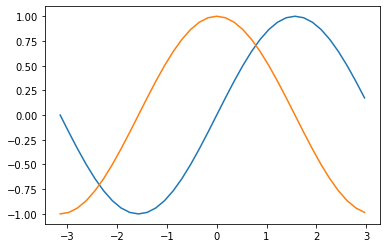

In [ ]:
import numpy as np 
x=np.arange(-np.pi,np.pi,np.pi/18)
y=np.sin(x)
y2=np.cos(x)
mat.plot(x,y)
mat.plot(x,y2)
mat.show()

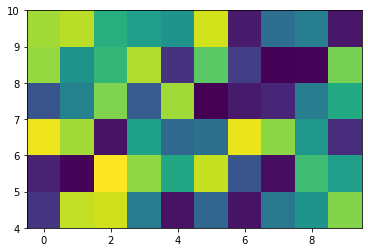

In [ ]:
import matplotlib.pyplot as mat
import numpy as np
np.random.seed(19680154)
x=np.arange(-.5,10,1)
y=np.arange(4.,11,1)
z=np.random.rand(6,10)
fig,ax=mat.subplots()
ax.pcolormesh(x,y,z)
mat.show()


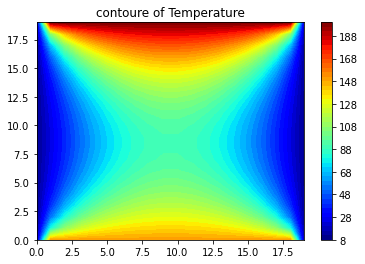

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

maxIter=500

lenX=lenY=20
delta=1

Ttop=200
Tbottom=150
Tleft=10
Tright=10

Tguess=30

colorinterpolation=50
colourMap=plt.cm.jet

X,Y=np.meshgrid(np.arange(0,lenX),np.arange(0,lenY))

T=np.empty((lenX,lenY))
T.fill(Tguess)
T[(lenY-1):,:]=Ttop
T[:1,:]=Tbottom
T[:,(lenX-1):]=Tright
T[:,:1]=Tleft
for iteration in range(0,maxIter):
    for i in range(1,lenX-1,delta):
        for j in range(1,lenY-1,delta):
            T[i,j]=0.25*(T[i+1][j]+T[i-1][j]+T[i][j+1]+T[i][j-1])
            
plt.title("contoure of Temperature") 
plt.contourf(X,Y,T,colorinterpolation,cmap=colourMap)
plt.colorbar()
plt.show()